In [47]:
import tensorflow

tensorflow.random.set_random_seed(5)
from numpy.random import seed

seed(5)
import time
import numpy as np

np.random.seed(5)

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import r2_score
from sklearn import preprocessing
import matplotlib.pyplot as plt
from tensorflow.python.keras.utils.vis_utils import plot_model

from math import sqrt
import pandas as pd

from tensorflow.python.keras.layers import merge
from tensorflow.python.keras.layers.core import *
from tensorflow.python.keras.layers.recurrent import LSTM
from tensorflow.python.keras.models import *
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Input, Dropout, Flatten, MaxPooling1D, TimeDistributed, GRU, SimpleRNN, \
    Bidirectional, RNN
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.python.framework.ops import disable_eager_execution
tf.test.is_gpu_available()
china_v = pd.read_csv('D:\project\pythonProject2\Japan.csv')
china_data = china_v['value']
scaler = MinMaxScaler()
LOOK_BACK = 12
FORECAST_RANGE = 1
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=20)  # 早停回调

In [48]:
def first_diff(data):
    """
    计算给定数据列表的相邻元素之间的差值。

    参数:
    data: 一个包含数字元素的列表或数组，可以是浮点数或整数。

    返回值:
    一个numpy数组，包含输入数据中相邻元素之间的差值，数据类型为float64。
    """
    # 初始化用于存储差值的列表
    data_diff = []
    # 计算相邻元素之间的差值，并添加到data_diff列表中
    for i in range(len(data) - 1):
        data_diff.append(data[i + 1] - data[i])
    # 将data_diff列表转换为numpy数组
    data_diff = np.array(data_diff)
    # 将数组的数据类型转换为float64并返回
    return data_diff.astype(np.float64)


def anti_first_diff(m, n):
    data = []
    for i in range(0, len(m)):
        a = n[i] + m[i]
        data.append(a)
    return np.array(data).astype("float32")


def split_sequence(sequence, look_back, forecast_horizon):
    X, y = list(), list()
    for i in range(len(sequence)):
        lag_end = i + look_back
        forecast_end = lag_end + forecast_horizon
        if forecast_end > len(sequence):
            break
        seq_x, seq_y = sequence[i:lag_end], sequence[lag_end:forecast_end]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


def inverse_transform(y_test, yhat):
    y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])
    yhat_reshaped = yhat.reshape(-1, yhat.shape[-1])
    yhat_inverse = scaler.inverse_transform(yhat_reshaped)
    y_test_inverse = scaler.inverse_transform(y_test_reshaped)
    return yhat_inverse, y_test_inverse


def rmse(x, y):
    return tf.sqrt(tf.reduce_mean(tf.square((x - y))))


# 让模型侧重于输入维度的第几个维度，attention_column，目前是10,第11维
def get_data_recurrent(x, y, attention_column=7):
    y = y.reshape(y.shape[0], 1)
    x[:, attention_column, :] = np.tile(y[:], (1, 1))
    return x, y


def attention_3d_block(inputs):
    a = Permute((2, 1))(inputs)
    a = Dense(LOOK_BACK, activation='softmax')(a)
    a_probs = Permute((2, 1))(a)
    # 相当于获得每一个step中，每个特征的权重
    output_attention_mul = merge.multiply([inputs, a_probs])  # 新版本 keras
    return output_attention_mul


def get_attention_model(time_steps, input_dim, lstm_units=64):
    inputs1 = Input(shape=(time_steps, input_dim))
    lstm_out = GRU(lstm_units, return_sequences=True)(inputs1)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = TimeDistributed(Dropout(0.1))(attention_mul)
    attention_mul = Flatten()(attention_mul)
    # attention_mul = Flatten()(lstm_out)
    output = Dense(1)(attention_mul)
    model = Model(inputs=[inputs1], outputs=output)
    return model
def no_attention_model(time_steps, input_dim, lstm_units=64):
    inputs1 = Input(shape=(time_steps, input_dim))
    lstm_out = GRU(lstm_units, return_sequences=True)(inputs1)
    # attention_mul = attention_3d_block(lstm_out)
    # attention_mul = Flatten()(attention_mul)
    attention_mul = Flatten()(lstm_out)
    attention_mul = Dropout(0.1)(attention_mul)
    output = Dense(1)(attention_mul)
    model = Model(inputs=[inputs1], outputs=output)
    return model


In [49]:
china_v1 = china_data[:1610]
china_v2 = china_data[1614:3224]
china_v3 = china_data[3225:4835]
china_v4 = china_data[4838:6448]
china_v5 = china_data[6450:8060]
china_v6 = china_data[8062:9672]

In [50]:
def data_preprocessing(china_v1):
    data = np.array(china_v1)
    data = data.reshape(-1, 1)
    tec_diff = first_diff(np.array(data))  # 进行差分进行平稳化
    split_size = int(len(tec_diff) * 0.7)  # 前70%为训练集后30%为测试集
    train, test = tec_diff[:split_size], tec_diff[split_size:]
    scaled_train = scaler.fit_transform(train)
    scaled_test = scaler.transform(test)  # fit_transform()的作用就是先拟合数据，然后转化它将其转化为标准形式
    x_train, y_train = split_sequence(scaled_train, look_back=LOOK_BACK,
                                      forecast_horizon=FORECAST_RANGE)  # fit_transform后使用前12个值预测第13个值
    x_test, y_test = split_sequence(scaled_test, look_back=LOOK_BACK,
                                forecast_horizon=FORECAST_RANGE)  # fit_transform后使用前12个值预测第13个值
    xa, ya = split_sequence(np.array(data[int(len(tec_diff) * 0.7) + 1:]), look_back=LOOK_BACK,
                        forecast_horizon=FORECAST_RANGE)  # 不进行归一化
    return x_train, y_train, scaled_test, scaled_test,x_test,y_test,xa,ya,data

In [51]:
def model(x_train, y_train,optimizer,betch_size):
    INPUT_DIMS = 1
    tf.random.set_random_seed(5)
    model = get_attention_model(LOOK_BACK, INPUT_DIMS)
    X, Y = get_data_recurrent(x_train, y_train)  # 将数据拼接
    model.compile(optimizer=optimizer, loss='mae')  # 实际优化器
    history = model.fit(X, Y, epochs=100, callbacks=[early_stop], batch_size=betch_size, verbose=2, shuffle=False,
                        validation_split=0.1)
    model.summary()  # 输出模型各层的参数状况
    return model
def model_no_attention(x_train, y_train,optimizer,betch_size):
    INPUT_DIMS = 1
    tf.random.set_random_seed(5)
    model = no_attention_model(LOOK_BACK, INPUT_DIMS)
    X, Y = get_data_recurrent(x_train, y_train)  # 将数据拼接
    model.compile(optimizer=optimizer, loss='mae')  # 实际优化器
    history = model.fit(X, Y, epochs=100, callbacks=[early_stop], batch_size=betch_size, verbose=1, shuffle=False,
                        validation_split=0.1)
    model.summary()  # 输出模型各层的参数状况
    return model

In [52]:
def result(data,yhat, y_test, ya):
    yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)  # 预测值反归一化
    y_pre = []
    for i in range(yhat_inverse.shape[0]):
        for j in range(yhat_inverse.shape[1]):
            y_pre.append(yhat_inverse[i][j])
            y = np.array(y_test_inverse)

    y_pre = np.array(y_pre)  # 将y_pre转化为numpy数组
    y = anti_first_diff(ya, y)
    y_pre = anti_first_diff(ya, y_pre)  # y是实际值，y_pre是预测值

    y_r, y_p = [], []  # y_r 真实值，y_p 预测值
    for i in range(0, y.shape[0]):
        for j in range(0, y.shape[1]):
            y_r.append(y[i][j])
            y_p.append(y_pre[i][j])
    y_r1 = np.array(y_r)
    y_p1 = np.array(y_p)
    y_r2 = data[1139:]
    x = np.arange(0, 1610, 1)
    MAE = mean_absolute_error(y_r2, y_p1)
    MSE = mean_squared_error(y_r2, y_p1)
    RMSE = sqrt(mean_squared_error(y_r2, y_p1))
    R2_score = r2_score(y_r2, y_p1)
    output_value = []
    output_value.append(MAE)
    output_value.append(MSE)
    output_value.append(RMSE)
    output_value.append(R2_score)
    output_value.append(int(using_time))
    output_value.append(y_p1)
    output_value = np.array(output_value)
    output_data = pd.DataFrame(output_value)

    output_data.index = ['MAE', 'MSE', 'RMSE', 'R2 Score', 'Time-consuming(s)','yhat']
    print(output_data)
    return output_data

In [53]:
x1=data_preprocessing(china_v1)
x2=data_preprocessing(china_v2)
start = time.perf_counter()
tf.random.set_random_seed(5)
model1=model(x1[0],x1[1],'SGD',64)
model1_no_attention=model_no_attention(x1[0],x1[1],'SGD',64)
yhat1=model1.predict(x1[4])
yhat1_no_attention=model1_no_attention.predict(x1[4])
using_time = time.perf_counter() - start
output1=result(x1[8],yhat1,x1[5],x1[7])
output1_no_attention=result(x1[8],yhat1_no_attention,x1[5],x1[7])

Train on 1002 samples, validate on 112 samples
Epoch 1/100
1002/1002 - 2s - loss: 0.4453 - val_loss: 0.3614
Epoch 2/100
1002/1002 - 0s - loss: 0.2907 - val_loss: 0.2210
Epoch 3/100
1002/1002 - 0s - loss: 0.1845 - val_loss: 0.1454
Epoch 4/100
1002/1002 - 0s - loss: 0.1399 - val_loss: 0.1225
Epoch 5/100
1002/1002 - 0s - loss: 0.1288 - val_loss: 0.1192
Epoch 6/100
1002/1002 - 0s - loss: 0.1271 - val_loss: 0.1189
Epoch 7/100
1002/1002 - 0s - loss: 0.1271 - val_loss: 0.1190
Epoch 8/100
1002/1002 - 0s - loss: 0.1269 - val_loss: 0.1190
Epoch 9/100
1002/1002 - 0s - loss: 0.1268 - val_loss: 0.1190
Epoch 10/100
1002/1002 - 0s - loss: 0.1268 - val_loss: 0.1190
Epoch 11/100
1002/1002 - 0s - loss: 0.1267 - val_loss: 0.1190
Epoch 12/100
1002/1002 - 0s - loss: 0.1269 - val_loss: 0.1190
Epoch 13/100
1002/1002 - 0s - loss: 0.1267 - val_loss: 0.1191
Epoch 14/100
1002/1002 - 0s - loss: 0.1267 - val_loss: 0.1191
Epoch 15/100
1002/1002 - 0s - loss: 0.1269 - val_loss: 0.1191
Epoch 16/100
1002/1002 - 0s - lo

D:\tools\anconda\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
D:\tools\anconda\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [54]:
x2=data_preprocessing(china_v2)
start = time.perf_counter()
tf.random.set_random_seed(5)
model2=model(x2[0],x2[1],'SGD',64)
model2_no_attention=model_no_attention(x2[0],x2[1],'SGD',64)
yhat2=model2.predict(x2[4])
yhat2_no_attention=model2_no_attention.predict(x2[4])
using_time = time.perf_counter() - start
output2=result(x2[8],yhat2,x2[5],x2[7])
output2_no_attention=result(x2[8],yhat2_no_attention,x2[5],x2[7])

Train on 1002 samples, validate on 112 samples
Epoch 1/100
1002/1002 - 2s - loss: 0.4059 - val_loss: 0.3170
Epoch 2/100
1002/1002 - 0s - loss: 0.2477 - val_loss: 0.1710
Epoch 3/100
1002/1002 - 0s - loss: 0.1368 - val_loss: 0.0976
Epoch 4/100
1002/1002 - 0s - loss: 0.1001 - val_loss: 0.0850
Epoch 5/100
1002/1002 - 0s - loss: 0.0952 - val_loss: 0.0844
Epoch 6/100
1002/1002 - 0s - loss: 0.0949 - val_loss: 0.0845
Epoch 7/100
1002/1002 - 0s - loss: 0.0949 - val_loss: 0.0845
Epoch 8/100
1002/1002 - 0s - loss: 0.0949 - val_loss: 0.0845
Epoch 9/100
1002/1002 - 0s - loss: 0.0949 - val_loss: 0.0845
Epoch 10/100
1002/1002 - 0s - loss: 0.0949 - val_loss: 0.0845
Epoch 11/100
1002/1002 - 0s - loss: 0.0949 - val_loss: 0.0845
Epoch 12/100
1002/1002 - 0s - loss: 0.0950 - val_loss: 0.0845
Epoch 13/100
1002/1002 - 0s - loss: 0.0949 - val_loss: 0.0845
Epoch 14/100
1002/1002 - 0s - loss: 0.0948 - val_loss: 0.0844
Epoch 15/100
1002/1002 - 0s - loss: 0.0948 - val_loss: 0.0844
Epoch 16/100
1002/1002 - 0s - lo

D:\tools\anconda\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
D:\tools\anconda\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [55]:
x3=data_preprocessing(china_v3)
start = time.perf_counter()
tf.random.set_random_seed(5)
model3=model(x3[0],x3[1],'SGD',64)
model3_no_attention=model_no_attention(x3[0],x3[1],'SGD',64)
yhat3=model3.predict(x3[4])
yhat3_no_attention=model3_no_attention.predict(x3[4])
using_time = time.perf_counter() - start
output3=result(x3[8],yhat3,x3[5],x3[7])
output3_no_attention=result(x3[8],yhat3_no_attention,x3[5],x3[7])

Train on 1002 samples, validate on 112 samples
Epoch 1/100
1002/1002 - 2s - loss: 0.3743 - val_loss: 0.2855
Epoch 2/100
1002/1002 - 0s - loss: 0.2145 - val_loss: 0.1298
Epoch 3/100
1002/1002 - 0s - loss: 0.0944 - val_loss: 0.0477
Epoch 4/100
1002/1002 - 0s - loss: 0.0614 - val_loss: 0.0416
Epoch 5/100
1002/1002 - 0s - loss: 0.0594 - val_loss: 0.0417
Epoch 6/100
1002/1002 - 0s - loss: 0.0593 - val_loss: 0.0416
Epoch 7/100
1002/1002 - 0s - loss: 0.0594 - val_loss: 0.0416
Epoch 8/100
1002/1002 - 0s - loss: 0.0594 - val_loss: 0.0416
Epoch 9/100
1002/1002 - 0s - loss: 0.0593 - val_loss: 0.0417
Epoch 10/100
1002/1002 - 0s - loss: 0.0593 - val_loss: 0.0417
Epoch 11/100
1002/1002 - 0s - loss: 0.0593 - val_loss: 0.0416
Epoch 12/100
1002/1002 - 0s - loss: 0.0593 - val_loss: 0.0416
Epoch 13/100
1002/1002 - 0s - loss: 0.0593 - val_loss: 0.0416
Epoch 14/100
1002/1002 - 0s - loss: 0.0593 - val_loss: 0.0416
Epoch 15/100
1002/1002 - 0s - loss: 0.0594 - val_loss: 0.0416
Epoch 16/100
1002/1002 - 0s - lo

D:\tools\anconda\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
D:\tools\anconda\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [56]:
x4=data_preprocessing(china_v4)
start = time.perf_counter()
tf.random.set_random_seed(5)
model4=model(x4[0],x4[1],'SGD',64)
model4_no_attention=model_no_attention(x4[0],x4[1],'SGD',64)
yhat4=model4.predict(x4[4])
yhat4_no_attention=model4_no_attention.predict(x4[4])
using_time = time.perf_counter() - start
output4=result(x4[8],yhat4,x4[5],x4[7])
output4_no_attention=result(x4[8],yhat4_no_attention,x4[5],x4[7])

Train on 1002 samples, validate on 112 samples
Epoch 1/100
1002/1002 - 2s - loss: 0.3603 - val_loss: 0.2860
Epoch 2/100
1002/1002 - 0s - loss: 0.2107 - val_loss: 0.1499
Epoch 3/100
1002/1002 - 0s - loss: 0.1126 - val_loss: 0.1056
Epoch 4/100
1002/1002 - 0s - loss: 0.0776 - val_loss: 0.1022
Epoch 5/100
1002/1002 - 0s - loss: 0.0760 - val_loss: 0.1022
Epoch 6/100
1002/1002 - 0s - loss: 0.0760 - val_loss: 0.1021
Epoch 7/100
1002/1002 - 0s - loss: 0.0759 - val_loss: 0.1023
Epoch 8/100
1002/1002 - 0s - loss: 0.0761 - val_loss: 0.1021
Epoch 9/100
1002/1002 - 0s - loss: 0.0760 - val_loss: 0.1021
Epoch 10/100
1002/1002 - 0s - loss: 0.0761 - val_loss: 0.1021
Epoch 11/100
1002/1002 - 0s - loss: 0.0761 - val_loss: 0.1021
Epoch 12/100
1002/1002 - 0s - loss: 0.0761 - val_loss: 0.1022
Epoch 13/100
1002/1002 - 0s - loss: 0.0761 - val_loss: 0.1022
Epoch 14/100
1002/1002 - 0s - loss: 0.0761 - val_loss: 0.1022
Epoch 15/100
1002/1002 - 0s - loss: 0.0761 - val_loss: 0.1022
Epoch 16/100
1002/1002 - 0s - lo

D:\tools\anconda\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
D:\tools\anconda\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [57]:
gru_rmse=[]
gru_rmse.append(output1_no_attention[0][2])
gru_rmse.append(output2_no_attention[0][2])
gru_rmse.append(output3_no_attention[0][2])
gru_rmse=np.array(gru_rmse)

In [58]:
gru_rmse.mean(),min(gru_rmse),max(gru_rmse)

(0.0332730932872158, 0.006463872026259566, 0.058322582098853284)

In [59]:
gru_rmse=[]
gru_rmse.append(output1[0][3])
gru_rmse.append(output2[0][3])
gru_rmse.append(output3[0][3])
gru_rmse=np.array(gru_rmse)

In [60]:
gru_rmse.mean(),min(gru_rmse),max(gru_rmse)

(0.9976224570585096, 0.9936185046791465, 0.9999472066561237)

In [61]:
output1[0][2],output2[0][2],output3[0][2]

(0.022185138131354493, 0.002620293582941288, 0.0001800701210123099)

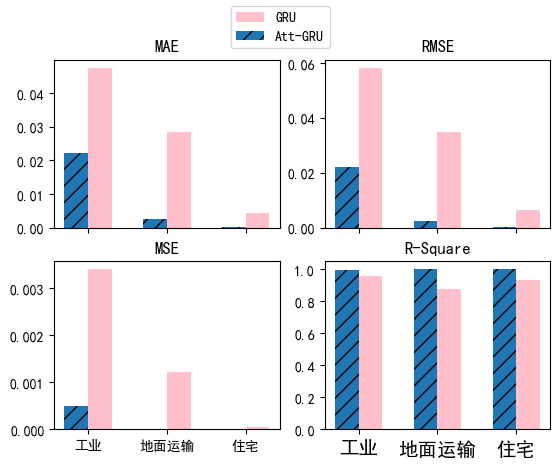

In [89]:
x_opt=[1,2,3]  # 确定柱状图数量,可以认为是x方向刻度
x_label = ['工业','地面运输','住宅']
f, ([ax1, ax2],[ax3,ax4]) = plt.subplots(2, 2, sharex=True)
plt.xticks(x_opt, x_label,fontsize=14)  # 绘制x刻度标签
y_att_mae=[output1[0][0],output2[0][0],output3[0][0]]
y_att_rmse=[output1[0][2],output2[0][2],output3[0][2]]
y_att_mse=[output1[0][1],output2[0][1],output3[0][1]]
y_gru_mae=[output1_no_attention[0][0],output2_no_attention[0][0],output3_no_attention[0][0]]
y_gru_rmse=[output1_no_attention[0][2],output2_no_attention[0][2],output3_no_attention[0][2]]
y_gru_mse=[output1_no_attention[0][1],output2_no_attention[0][1],output3_no_attention[0][1]]
y_att_r2=[output1[0][3],output2[0][3],output3[0][3]]
y_gru_r2=[output1_no_attention[0][3],output2_no_attention[0][3],output3_no_attention[0][3]]
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False		# 显示负号
ax1.bar(x_opt,y_gru_mae,width=0.3,color='pink',align='edge',label='GRU')
ax1.bar(x_opt,y_att_mae,width=-0.3,align='edge',label='Att-GRU',hatch='//')
ax1.set_title('MAE')
ax2.bar(x_opt,y_att_rmse,width=-0.3,align='edge',label='Att-GRU',hatch='//')
ax2.bar(x_opt,y_gru_rmse,width=0.3,color='pink',align='edge',label='GRU')
ax2.set_title('RMSE')
ax3.bar(x_opt,y_att_mse,width=-0.3,align='edge',label='Att-GRU',hatch='//')
ax3.bar(x_opt,y_gru_mse,width=0.3,color='pink',align='edge',label='GRU')
ax3.set_title('MSE')
ax4.bar(x_opt,y_gru_r2,width=0.3,color='pink',align='edge',label='GRU')
ax4.bar(x_opt,y_att_r2,width=-0.3,align='edge',label='Att-GRU',hatch='//')
ax4.set_title('R-Square')
lines, labels = f.axes[0].get_legend_handles_labels()
f.legend(lines, labels, loc = 'upper center')
plt.show()
# plt.xticks(x_opt, x_label)  # 绘制x刻度标签
# plt.bar(x_opt,y_opt_r2,width=0.3,align='center',label='R2')
# plt.ylim(0.875,1.05)
# plt.legend()
# plt.show()

In [70]:
yhat=[]
yhat=np.array(yhat)
yhat=np.concatenate((output2[0][5],output3[0][5],output4[0][5]))
yr=[]
yr=np.array(yr)
yr=np.concatenate((x2[8][1139:],x3[8][1139:],x4[8][1139:]))

In [85]:
y=np.vstack((yhat,yr))

In [124]:
dif=np.diff(y,axis=0)

In [125]:
min(dif),max(dif)

(array([-0.28864051]), array([0.62041812]))

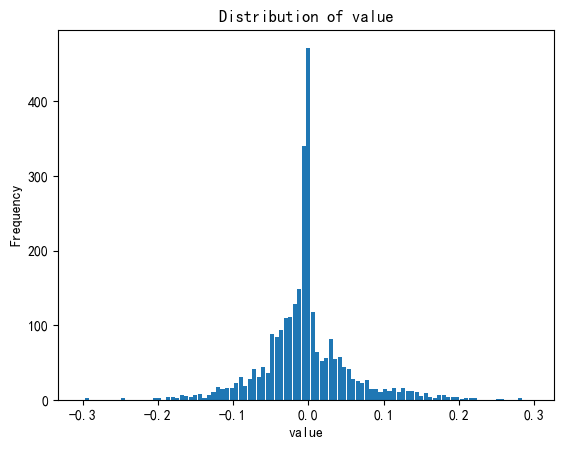

In [140]:
hist, bins = np.histogram(dif, bins='auto',range=(-0.3, 0.3))

# 设置柱子宽度和对齐方式
bar_width = (bins[1] - bins[0]) * 0.9  # 假设柱子宽度为原bin宽度的80%
bar_align = 'center'  # 柱子中心对齐

# 绘制直方图
plt.bar(bins[:-1], hist, width=bar_width, align=bar_align)

plt.xlabel('value')
plt.ylabel('Frequency')
plt.title('Distribution of value')
# plt.xlim(-0.2, 0.2)  # 设置x轴范围
plt.show()

In [101]:
yhat_GRU=[]
yhat_GRU=np.array(yhat_GRU)
yhat_GRU=np.concatenate((output2_no_attention[0][5],output3_no_attention[0][5],output4_no_attention[0][5]))
yr_GRU=[]
yr_GRU=np.array(yr_GRU)
yr_GRU=np.concatenate((x2[8][1139:],x3[8][1139:],x4[8][1139:]))
y_GRU=np.vstack((yhat_GRU,yr_GRU))
dif_GRU=np.diff(y_GRU,axis=0)

In [117]:
min(dif_GRU),max(dif_GRU)

(array([-0.288611]), array([0.61959947]))

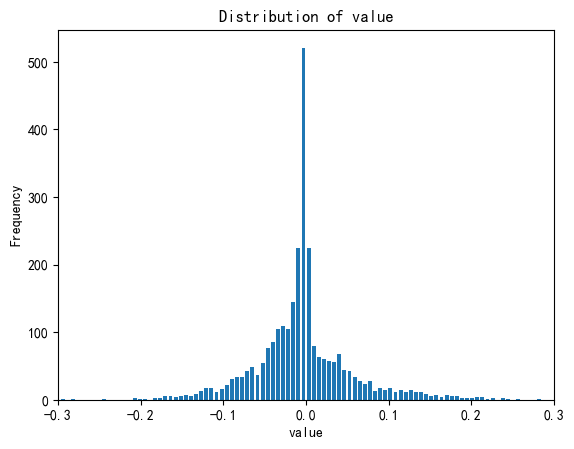

In [138]:
hist1, bins1 = np.histogram(dif_GRU, bins='auto', range=(-0.3, 0.3))

# 设置柱子宽度和对齐方式
bar_width1 = (bins[1] - bins[0]) * 0.8  # 假设柱子宽度为原bin宽度的80%
bar_align1 = 'center'  # 柱子中心对齐

# 绘制直方图
plt.bar(bins1[:-1], hist1, width=bar_width1, align=bar_align1,)


plt.xlabel('value')
plt.ylabel('Frequency')
plt.title('Distribution of value')
plt.xlim(-0.3, 0.3)  # 设置x轴范围
plt.show()

In [143]:
type(output2[0][5])

numpy.ndarray

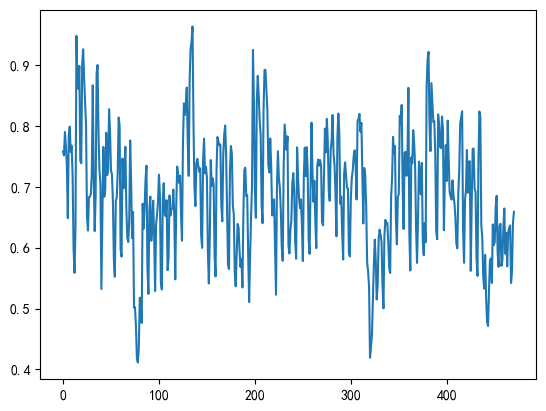

In [144]:
plt.plot(output2[0][5])
plt.show()

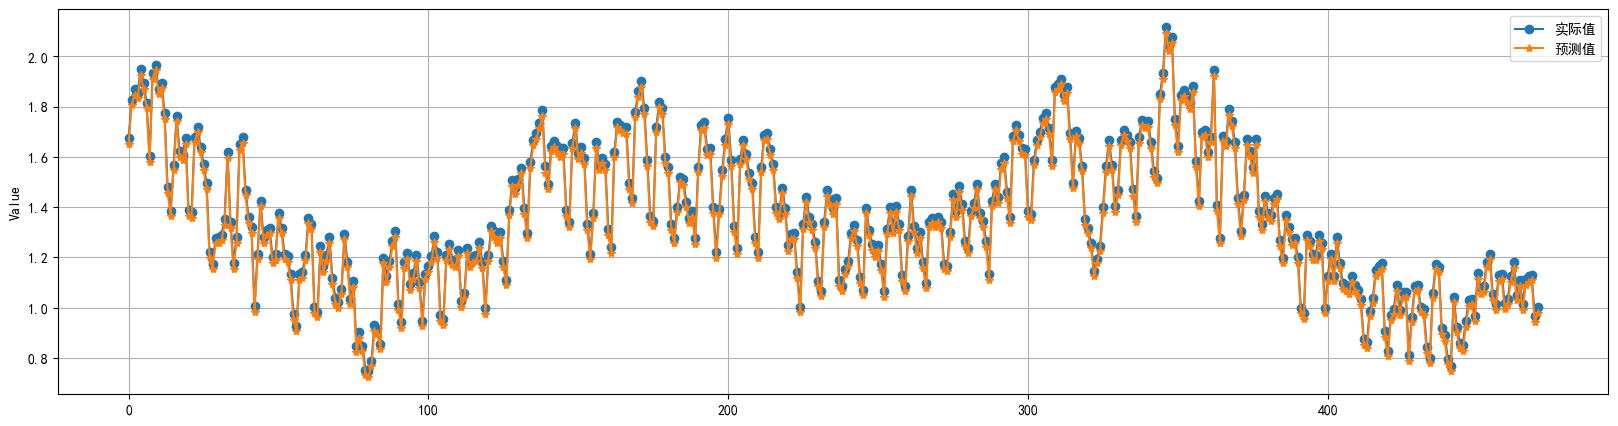

In [180]:
plt.figure(figsize=(20, 5))
plt.plot(output1[0][5],  linestyle='-',marker='o',label='实际值')
plt.plot(x1[8][1139:],  linestyle='-',marker='*',label='预测值')
plt.legend ()
plt.ylabel('Value')
plt.grid(True)

TypeError: text() missing 1 required positional argument: 's'

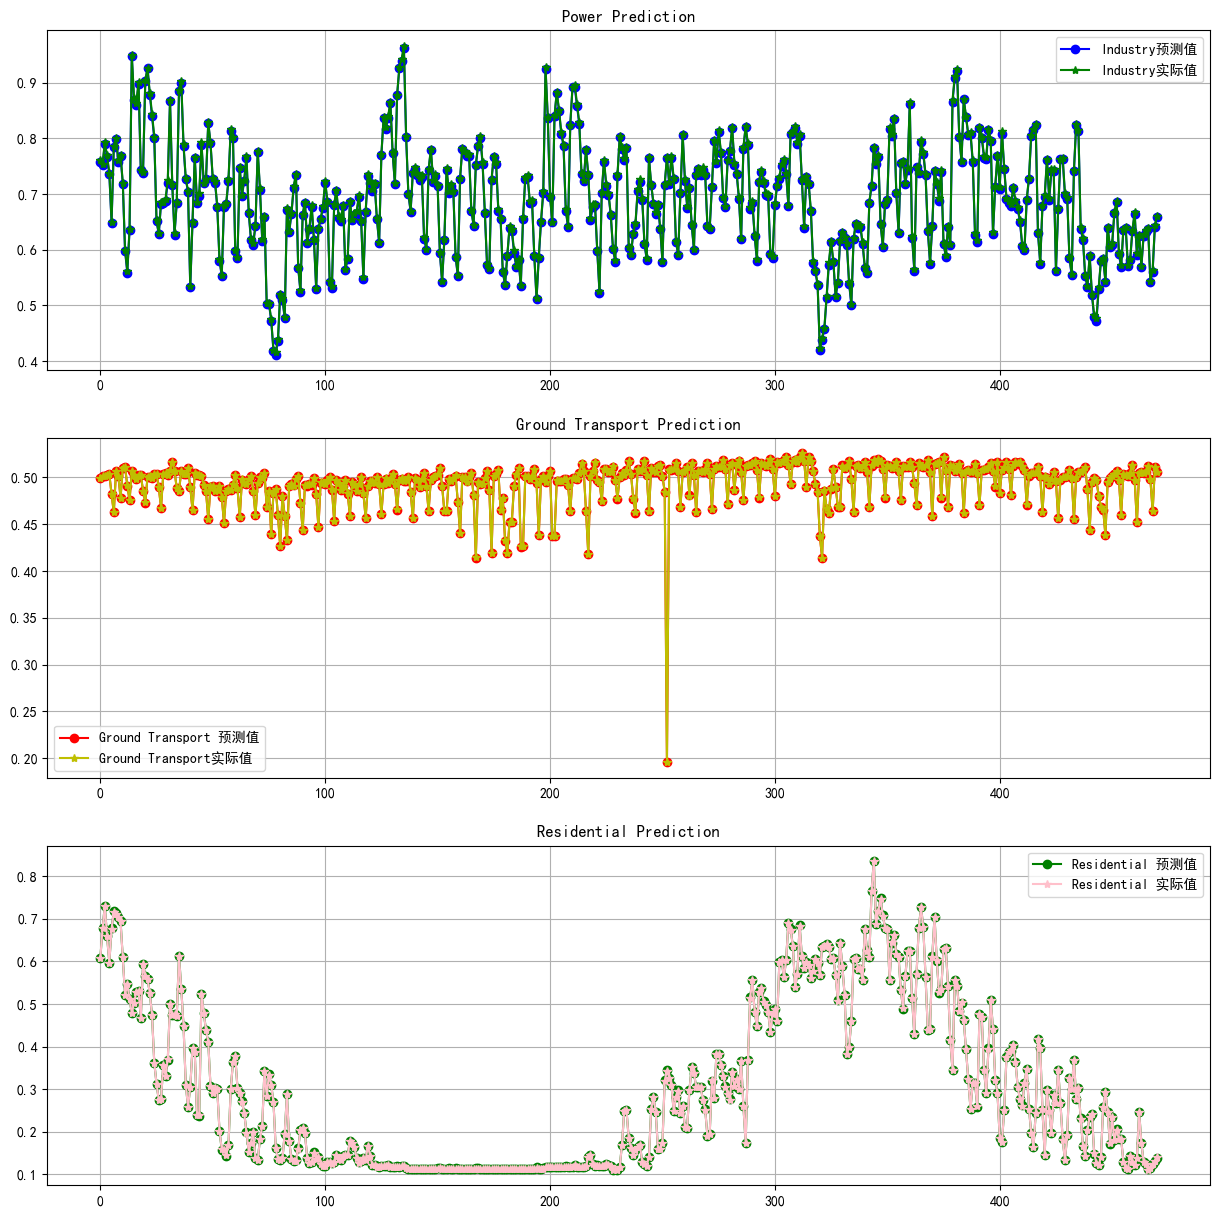

In [181]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))

# 绘制每个数组的折线图
axs[0].plot(output2[0][5], marker='o', linestyle='-', color='b', label='Industry预测值')
axs[0].plot(x2[8][1139:], marker='*', linestyle='-', color='g', label='Industry实际值')
axs[0].set_title('Power Prediction')
axs[0].grid(True)
axs[0].legend()

axs[1].plot(output3[0][5], marker='o', linestyle='-', color='r', label='Ground Transport 预测值')
axs[1].plot(x3[8][1139:], marker='*', linestyle='-', color='y', label='Ground Transport实际值')
axs[1].set_title('Ground Transport Prediction')
axs[1].grid(True)
axs[1].legend()

axs[2].plot(output4[0][5], marker='o', linestyle='-', color='g', label='Residential 预测值')
axs[2].plot(x4[8][1139:], marker='*', linestyle='-', color='pink', label='Residential 实际值')
axs[2].set_title('Residential Prediction')
axs[2].grid(True)
axs[2].legend()

# 添加共享的x轴标签
fig.text(0.5, -0.02, ha='center', fontsize=12)

plt.tight_layout()  # 调整子图间的间距
plt.show()

In [178]:
output1

,0
MAE,0.022154
MSE,0.000492
RMSE,0.022185
R2 Score,0.993619
Time-consuming(s),51
yhat,"[[1.6731176], [1.8269563], [1.8691789], [1.855..."
